In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set a consistent style for all visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

In [3]:
# Load the data
data = pd.read_csv('jets_data_updated.csv')

In [4]:
# Display the first few rows to understand the structure
data.head()

,Aircraft Type,Aircraft ID,Purchase Timestamp,Usage Hours,Performance Metrics,Maintenance Logs,Number of Failures,Parts with Issues,State,Area,Battalion,Temperature,Weather
0,Type D,A-785,2015-09-21,3726,69.11,3,1,NaN,West Bengal,North Zone,Delta Squadron,26.4,Rainy
1,Type E,A-532,2022-10-28,4142,93.85,23,3,NaN,Uttar Pradesh,Central Command,Alpha Battalion,11.3,Sunny
2,Type C,A-905,2021-12-06,4731,69.76,29,1,Transmission,Tamil Nadu,South Zone,Bravo Battalion,14.6,Stormy
3,Type A,A-338,2018-11-09,8904,83.10,23,7,NaN,Rajasthan,Central Command,Bravo Battalion,25.0,Foggy
4,Type D,A-474,2024-02-22,3707,87.54,25,4,Armor Plating,Kerala,West Zone,Bravo Battalion,41.0,Sunny


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10872 entries, 0 to 10871
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Aircraft Type        10872 non-null  object 
 1   Aircraft ID          10872 non-null  object 
 2   Purchase Timestamp   10872 non-null  object 
 3   Usage Hours          10872 non-null  int64  
 4   Performance Metrics  10872 non-null  float64
 5   Maintenance Logs     10872 non-null  int64  
 6   Number of Failures   10872 non-null  int64  
 7   Parts with Issues    5515 non-null   object 
 8   State                10872 non-null  object 
 9   Area                 10872 non-null  object 
 10  Battalion            10872 non-null  object 
 11  Temperature          10872 non-null  float64
 12  Weather              10872 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 1.1+ MB


In [6]:
data.describe()

,Usage Hours,Performance Metrics,Maintenance Logs,Number of Failures,Temperature
count,10872.000000,10872.000000,10872.000000,10872.000000,10872.000000
mean,5024.561074,80.048302,25.062270,4.177796,27.600681
std,2864.786482,11.548685,14.760595,2.495388,10.135307
min,102.000000,60.000000,0.000000,0.000000,10.000000
25%,2555.500000,70.050000,12.000000,2.000000,18.800000
50%,5030.500000,80.050000,25.000000,4.000000,27.800000
75%,7524.000000,89.992500,38.000000,6.000000,36.300000
max,10000.000000,100.000000,50.000000,10.000000,45.000000


In [7]:
# Check for missing values
print("Missing Values:")
data.isnull().sum()

Missing Values:


Aircraft Type             0
Aircraft ID               0
Purchase Timestamp        0
Usage Hours               0
Performance Metrics       0
Maintenance Logs          0
Number of Failures        0
Parts with Issues      5357
State                     0
Area                      0
Battalion                 0
Temperature               0
Weather                   0
dtype: int64

In [8]:
# Data Visualization Section
# Create a directory for saving visualizations
import os
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

# 1. Distribution of Aircraft Types
plt.figure(figsize=(10, 6))
type_counts = data['Aircraft Type'].value_counts()
sns.barplot(x=type_counts.index, y=type_counts.values)
plt.title('Distribution of Aircraft Types', fontsize=14)
plt.xlabel('Aircraft Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualizations/aircraft_type_distribution.png')
plt.close()

# 2. Distribution of Performance Metrics
plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

# Histogram
plt.subplot(gs[0])
sns.histplot(data['Performance Metrics'], bins=15, kde=True)
plt.title('Distribution of Performance Metrics', fontsize=14)
plt.xlabel('Performance Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Boxplot
plt.subplot(gs[1])
sns.boxplot(y=data['Performance Metrics'])
plt.title('Boxplot of Performance', fontsize=14)
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('visualizations/performance_distribution.png')
plt.close()

In [9]:
# Define classification categories based on performance metrics
def classify_performance(performance):
    if performance >= 90:
        return "Good condition"
    elif performance >= 80:
        return "Working but needs attention"
    elif performance >= 70:
        return "Work is required"
    else:
        return "Retire"

In [10]:
# Apply the classification
data['Condition_Category'] = data['Performance Metrics'].apply(classify_performance)

([0, 1, 2, 3],
 [Text(0, 0, 'Good condition'),
  Text(1, 0, 'Retire'),
  Text(2, 0, 'Work is required'),
  Text(3, 0, 'Working but needs attention')])

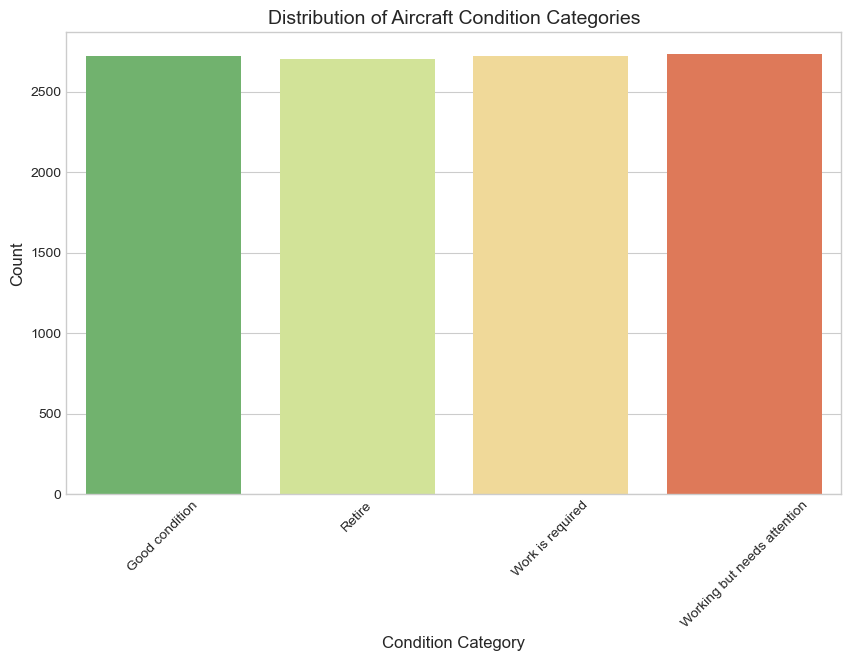

In [11]:
# 3. Distribution of Condition Categories
plt.figure(figsize=(10, 6))
category_counts = data['Condition_Category'].value_counts().sort_index()
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette="RdYlGn_r")
plt.title('Distribution of Aircraft Condition Categories', fontsize=14)
plt.xlabel('Condition Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

In [12]:
# Add percentage labels on top of each bar
total = len(data)
for i, p in enumerate(ax.patches):
    percentage = 100 * p.get_height() / total
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualizations/condition_category_distribution.png')
plt.close()

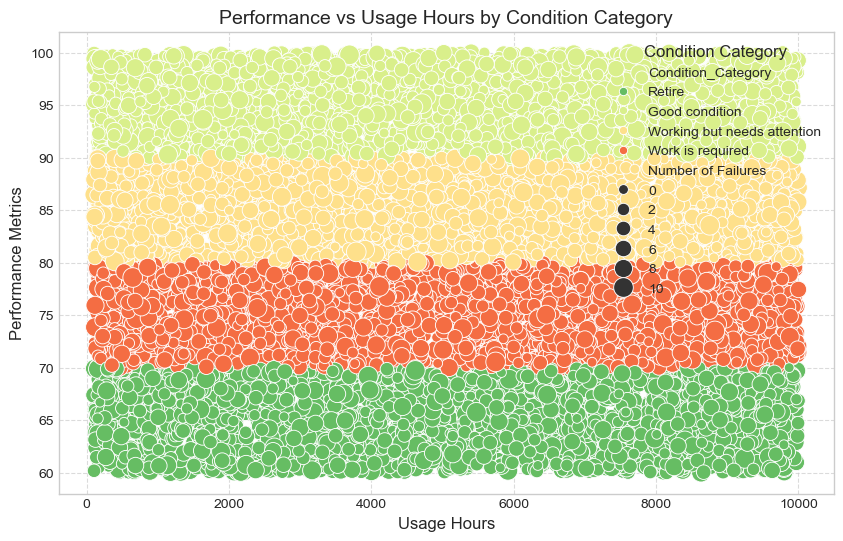

In [13]:
# 4. Performance vs Usage Hours scatter plot with condition category
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='Usage Hours', y='Performance Metrics', 
                         hue='Condition_Category', 
                         palette='RdYlGn_r',
                         size='Number of Failures', 
                         sizes=(50, 200),
                         data=data)
plt.title('Performance vs Usage Hours by Condition Category', fontsize=14)
plt.xlabel('Usage Hours', fontsize=12)
plt.ylabel('Performance Metrics', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title='Condition Category', title_fontsize=12, fontsize=10, loc='upper right')

In [14]:
# Add horizontal lines to show classification thresholds
plt.axhline(y=90, color='green', linestyle='--', alpha=0.8, label='Good condition threshold')
plt.axhline(y=80, color='gold', linestyle='--', alpha=0.8, label='Needs attention threshold')
plt.axhline(y=70, color='orange', linestyle='--', alpha=0.8, label='Work required threshold')

plt.tight_layout()
plt.savefig('visualizations/performance_vs_usage.png')
plt.close()

In [15]:
# 5. Relationship between Number of Failures and Performance
plt.figure(figsize=(12, 6))
sns.regplot(x='Number of Failures', y='Performance Metrics', data=data, 
           scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship between Number of Failures and Performance', fontsize=14)
plt.xlabel('Number of Failures', fontsize=12)
plt.ylabel('Performance Metrics', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualizations/failures_vs_performance.png')
plt.close()

In [16]:
# 6. Performance by State (geographic analysis)
plt.figure(figsize=(10, 6))
state_perf = data.groupby('State')['Performance Metrics'].mean().sort_values(ascending=False)
sns.barplot(x=state_perf.index, y=state_perf.values)
plt.title('Average Performance Metrics by State', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Average Performance', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualizations/performance_by_state.png')
plt.close()

In [17]:
# 7. Relationship between Temperature and Performance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature', y='Performance Metrics', hue='Condition_Category', data=data, palette='RdYlGn_r')
plt.title('Temperature vs Performance', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Performance Metrics', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualizations/temperature_vs_performance.png')
plt.close()

In [18]:
# 8. Heat map of correlations between numerical features
plt.figure(figsize=(10, 7))
numerical_features = ['Performance Metrics', 'Usage Hours', 'Number of Failures', 
                     'Maintenance Logs', 'Temperature']
correlation_matrix = data[numerical_features].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', 
           fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.savefig('visualizations/correlation_heatmap.png')
plt.close()

In [19]:
# 9. Parts with Issues Distribution
plt.figure(figsize=(10, 5))
parts_issues = data['Parts with Issues'].value_counts().sort_values(ascending=False)
sns.barplot(x=parts_issues.index, y=parts_issues.values)
plt.title('Distribution of Parts with Issues', fontsize=14)
plt.xlabel('Part Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualizations/parts_issues_distribution.png')
plt.close()

In [20]:
# 10. Age analysis (based on purchase timestamp)
data['Purchase Year'] = pd.to_datetime(data['Purchase Timestamp']).dt.year
plt.figure(figsize=(10, 5))
age_performance = data.groupby('Purchase Year')['Performance Metrics'].mean()
sns.lineplot(x=age_performance.index, y=age_performance.values, marker='o', linewidth=2)
plt.title('Average Performance Metrics by Purchase Year', fontsize=14)
plt.xlabel('Purchase Year', fontsize=12)
plt.ylabel('Average Performance', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualizations/performance_by_age.png')
plt.close()

In [21]:
# 11. Battalion Performance Comparison
plt.figure(figsize=(10, 4))
battalion_perf = data.groupby('Battalion')['Performance Metrics'].mean().sort_values(ascending=False)
sns.barplot(x=battalion_perf.index, y=battalion_perf.values)
plt.title('Average Performance Metrics by Battalion', fontsize=14)
plt.xlabel('Battalion', fontsize=12)
plt.ylabel('Average Performance', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualizations/performance_by_battalion.png')
plt.close()



In [22]:
# 12. Maintenance Logs vs Performance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Maintenance Logs', y='Performance Metrics', 
               hue='Condition_Category', size='Number of Failures',
               sizes=(50, 200), data=data, palette='RdYlGn_r')
plt.title('Maintenance Logs vs Performance', fontsize=14)
plt.xlabel('Number of Maintenance Logs', fontsize=12)
plt.ylabel('Performance Metrics', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualizations/maintenance_vs_performance.png')
plt.close()

In [23]:
# 14. Pair plot for key features
key_features = ['Performance Metrics', 'Usage Hours', 'Number of Failures', 'Maintenance Logs']
plt.figure(figsize=(16, 12))
pair_plot = sns.pairplot(data, vars=key_features, hue='Condition_Category', palette='RdYlGn_r')
plt.subplots_adjust(top=0.95)
pair_plot.fig.suptitle('Pairplot of Key Features by Condition Category', fontsize=16)
plt.tight_layout()
plt.savefig('visualizations/pairplot_key_features.png')
plt.close()

<Figure size 1600x1200 with 0 Axes>

In [4]:
# Function to add noise to the numerical features of the dataset
def add_noise(data, noise_level=0.1):
    noisy_data = data.copy()
    for column in noisy_data.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(0, noise_level * noisy_data[column].std(), size=noisy_data[column].shape)
        noisy_data[column] += noise
    return noisy_data

In [5]:
# Define classification categories based on performance metrics
def classify_performance(performance):
    if performance >= 90:
        return "Good condition"
    elif performance >= 80:
        return "Working but needs attention"
    elif performance >= 70:
        return "Work is required"
    else:
        return "Retire"

# Apply the classification
data['Condition_Category'] = data['Performance Metrics'].apply(classify_performance)

In [6]:
# Feature selection and preparation
features = ['Performance Metrics', 'Usage Hours', 'Number of Failures', 'Maintenance Logs']
X = data[features]
y = data['Condition_Category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Add noise to the datasets
noise_level = 0.1  # Adjust the noise level as needed
X_train_noisy = add_noise(X_train, noise_level)
X_test_noisy = add_noise(X_test, noise_level)

In [8]:
numeric_features = ['Performance Metrics', 'Usage Hours', 'Number of Failures', 'Maintenance Logs']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ])



In [9]:
# 1. Decision Tree Model
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [10]:
# Hyperparameter tuning for Decision Tree
param_grid_dt = {
    'classifier__max_depth': [3, 4, 5, 6, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}
grid_search_dt = GridSearchCV(dt_pipeline, param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train_noisy, y_train)
print("Best Decision Tree Parameters:")
print(grid_search_dt.best_params_)

Best Decision Tree Parameters:
{'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


In [11]:
# Use the best model
dt_best = grid_search_dt.best_estimator_
# Train Decision Tree model with best parameters
dt_best.fit(X_train_noisy, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Performance Metrics',
                                                   'Usage Hours',
                                                   'Number of Failures',
                                                   'Maintenance Logs'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

In [12]:
# Predict and evaluate
dt_predictions = dt_best.predict(X_test_noisy)
print("Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, dt_predictions))

Decision Tree Results:
Accuracy: 0.9276517473942366


In [13]:
print("Classification Report:")
print(classification_report(y_test, dt_predictions))

Classification Report:
                             precision    recall  f1-score   support

             Good condition       0.96      0.93      0.95       826
                     Retire       0.95      0.96      0.96       812
           Work is required       0.93      0.89      0.91       821
Working but needs attention       0.88      0.92      0.90       803

                   accuracy                           0.93      3262
                  macro avg       0.93      0.93      0.93      3262
               weighted avg       0.93      0.93      0.93      3262



In [14]:
# Hyperparameter tuning for SVM
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])



In [15]:
param_grid_svm = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.1, 0.01]
}
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train_noisy, y_train)
print("Best SVM Parameters:")
print(grid_search_svm.best_params_)


Best SVM Parameters:
{'classifier__C': 100, 'classifier__gamma': 0.1}


In [16]:
# Use the best model
svm_best = grid_search_svm.best_estimator_
# Train SVM model with best parameters
svm_best.fit(X_train_noisy, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Performance Metrics',
                                                   'Usage Hours',
                                                   'Number of Failures',
                                                   'Maintenance Logs'])])),
                ('classifier', SVC(C=100, gamma=0.1, random_state=42))])

In [17]:
# Predict and evaluate
svm_predictions = svm_best.predict(X_test_noisy)
print("SVM Results:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))

SVM Results:
Accuracy: 0.9264255058246474


In [18]:
print("Classification Report:")
print(classification_report(y_test, svm_predictions))

Classification Report:
                             precision    recall  f1-score   support

             Good condition       0.95      0.95      0.95       826
                     Retire       0.95      0.96      0.95       812
           Work is required       0.91      0.90      0.90       821
Working but needs attention       0.90      0.90      0.90       803

                   accuracy                           0.93      3262
                  macro avg       0.93      0.93      0.93      3262
               weighted avg       0.93      0.93      0.93      3262



In [19]:
# Confusion Matrix for Decision Tree
dt_confusion_matrix = confusion_matrix(y_test, dt_predictions)
print("Decision Tree Confusion Matrix:")
print(dt_confusion_matrix)


Decision Tree Confusion Matrix:
[[772   0   0  54]
 [  0 783  29   0]
 [  0  44 731  46]
 [ 33   0  30 740]]


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

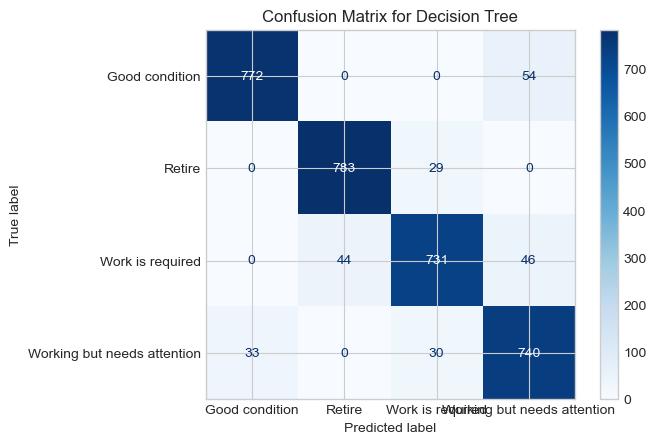

In [22]:
# Visualizing the Decision Tree Confusion Matrix
dt_disp = ConfusionMatrixDisplay(confusion_matrix=dt_confusion_matrix, display_labels=dt_best.classes_)
dt_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Decision Tree')
plt.show()

In [23]:
# Confusion Matrix for SVM
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions)
print("SVM Confusion Matrix:")
print(svm_confusion_matrix)


SVM Confusion Matrix:
[[787   0   0  39]
 [  0 777  35   0]
 [  0  44 735  42]
 [ 44   0  36 723]]


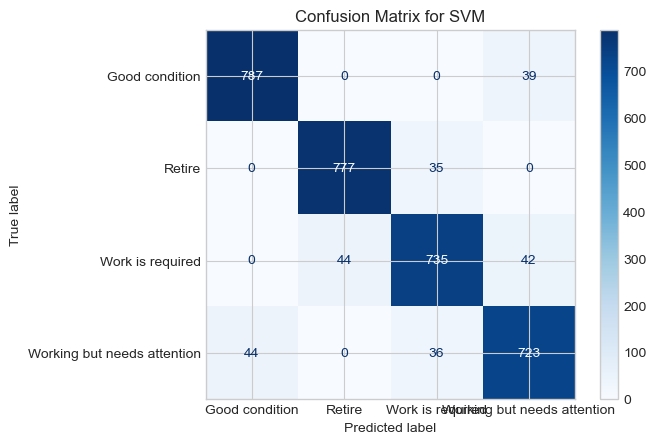

In [24]:
# Visualizing the SVM Confusion Matrix
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_confusion_matrix, display_labels=svm_best.classes_)
svm_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM')
plt.show()

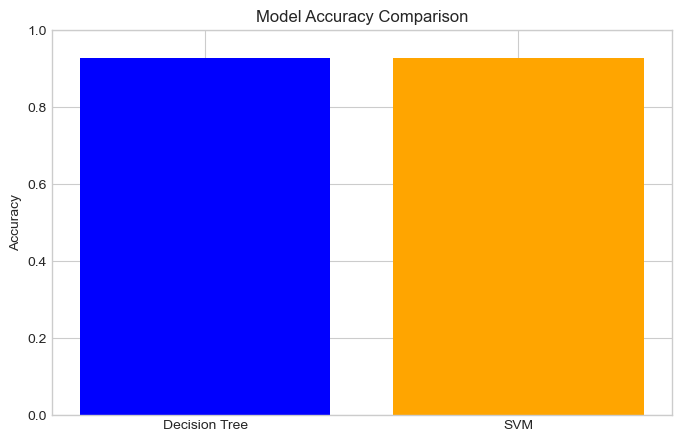

In [25]:
# Additional Visualizations: Accuracy Comparison
model_names = ['Decision Tree', 'SVM']
accuracies = [accuracy_score(y_test, dt_predictions), accuracy_score(y_test, svm_predictions)]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

In [30]:
import pandas as pd

def predict_aircraft(aircraft_id):
    # Define the features to extract
    features_list = ['Performance Metrics', 'Usage Hours', 'Number of Failures', 'Maintenance Logs']
    
    # Extract the relevant row from the dataset
    aircraft_data = data[data['Aircraft ID'] == aircraft_id]
    
    if aircraft_data.empty:
        return f"No data found for Aircraft ID: {aircraft_id}"
    
    # Extract features for prediction and convert to DataFrame
    features = pd.DataFrame(aircraft_data[features_list].values, columns=features_list)
    performance_metrics = aircraft_data['Performance Metrics'].values[0]
    
    # Make predictions using the trained models
    svm_prediction = svm_best.predict(features)[0]
    dt_prediction = dt_best.predict(features)[0]
    
    # Prepare the output
    prediction_output = {
        'Aircraft ID': aircraft_id,
        'SVM Prediction': svm_prediction,
        'Decision Tree Prediction': dt_prediction,
        'Additional Details': {
            'Aircraft Type': aircraft_data['Aircraft Type'].values[0],
            'Area': aircraft_data['Area'].values[0],
            'Battalion': aircraft_data['Battalion'].values[0],
            'Temperature': aircraft_data['Temperature'].values[0],
            'Weather Conditions': aircraft_data['Weather'].values[0],
            'Usage Hours': aircraft_data['Usage Hours'].values[0],
            'Number of Failures': aircraft_data['Number of Failures'].values[0],
            'Performance Metrics': performance_metrics
        }
    }
    
    return prediction_output

# Example usage
aircraft_id = 'A-738'  # Replace with the desired Aircraft ID
prediction = predict_aircraft(aircraft_id)
print(prediction)

{'Aircraft ID': 'A-738', 'SVM Prediction': 'Working but needs attention', 'Decision Tree Prediction': 'Working but needs attention', 'Additional Details': {'Aircraft Type': 'Type B', 'Area': 'East Zone', 'Battalion': 'Alpha Battalion', 'Temperature': 16.1, 'Weather Conditions': 'Windy', 'Usage Hours': 5767, 'Number of Failures': 0, 'Performance Metrics': 81.59}}
